# Install AutoML

In [2]:
!apt-get install swig -y
!pip install Cython numpy

!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [4]:
!pip install auto-sklearn

In [5]:
import autosklearn.classification


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# AutoML

## Functions

In [0]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [0]:
#%% md
#### MyPCA
#%%
def myPCA(data,n):
    pca = PCA(n_components=n)
    pca.fit(data)
    df = pca.transform(data)
    PCA_Data = pd.DataFrame(df)
    return PCA_Data

#%% md
#### myNormalize
#%%
def myNormalize(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    Normalized_Data = min_max_scaler.fit_transform(data)
    Normalized_Data = pd.DataFrame(Normalized_Data)
    return Normalized_Data

#%% md
#### myEncode
#%%
def myEncode(data,col): 
    NewData_Encode = data.copy()
    NewData_Encode = pd.get_dummies(NewData_Encode, columns=col, prefix = col)
    return NewData_Encode


#%% md
#### myCleanAndTransformData
#%%
def myCleanAndTransformData(data):
    
    #Drop null rows
    NewData = data.dropna()
    #Remove unknown ata
    NewData = NewData[NewData['episodes']!='Unknown']
    #Add a new column rating class 
    NewData['Class']=1
    # 1: High
    # or 0: Low based on rating
    NewData.loc[NewData['rating'] >= NewData['rating'].mean(), 'Class'] = 1
    NewData.loc[NewData['rating'] < NewData['rating'].mean(), 'Class'] = 0
    
    #Split genre values into rows
    NewData = pd.DataFrame(NewData.genre.str.split(',').tolist(), index=[NewData.anime_id,NewData.type,NewData.episodes,NewData.rating,NewData.members,NewData.Class]).stack()
    NewData = NewData.reset_index([0,'anime_id','type','episodes','rating','members','Class'])
    NewData.columns=['anime_id','type','episodes','rating','members','Class','genre']
    
    #Encode type feature: 6 unique values
    NewData = myEncode(NewData,['type'])
 
    #Encode genre feature: 82 unique values
    NewData = myEncode(NewData,['genre'])
 
     #Drop anmie_id,rating,Class
    NewData = NewData.drop(['rating'],axis=1)
    NewData = NewData.drop(columns=['anime_id'])
    #NewData = NewData.drop(columns=['episodes'])  
    
    return NewData


#%% md
#### mySplitData
#%%
def mySplitData(X_Data,Y_Data,test_size,random_state):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_Data, Y_Data, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def mySplitDataByTrainSize(X_Data,Y_Data,train_size,random_state):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_Data, Y_Data, train_size=train_size, random_state=random_state)
    X_train, X_test, y_train, y_test = mySplitData(X_train,y_train,0.33,random_state)
    return X_train, X_test, y_train, y_test

In [15]:
#%% md
# Load data from files
#%%
RawData = pd.read_csv('anime.csv')
RawData.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [16]:
#%% md
#### Clean and Transform Data
#%%
Cleaned_Data = myCleanAndTransformData(RawData)
Y_Data = Cleaned_Data['Class']
X_Data = Cleaned_Data.drop(columns=['Class'])

#%% md
#### Normalize  Data
#%%
Normalized_Data = myNormalize(X_Data)
#%% md
#### PCA
#%%
n_components=40
PCA_Data = myPCA(Normalized_Data,n_components)
PCA_Data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,-0.311566,0.786508,-0.420821,0.005236,-0.078664,-0.049645,-0.062636,0.007171,-0.075350,-0.030938,0.086265,-0.139423,-0.157023,0.028296,-0.081142,-0.232689,-0.299072,0.804718,-0.258789,-0.007697,-0.094827,-0.108054,-0.062482,0.025710,0.003345,-0.024982,-0.033484,-0.004927,-0.011708,-0.006766,-0.011789,-0.014352,0.009456,-0.010511,-0.008306,-0.003907,0.005473,-0.013950,-0.006672,-0.005472
1,-0.284842,0.763991,-0.412009,-0.010872,-0.110067,-0.087028,-0.096769,0.054629,-0.179466,-0.045545,0.764386,0.581467,0.033980,-0.066736,0.030945,0.068189,0.010380,-0.031949,-0.043617,0.008152,-0.027468,-0.040192,-0.033368,0.004743,0.006577,-0.016136,-0.028665,-0.009426,-0.005297,-0.004070,-0.007261,-0.012869,0.006336,-0.011367,-0.008377,-0.001193,0.008558,-0.013429,-0.008346,-0.006490
2,-0.284838,0.767910,-0.395570,-0.007614,-0.091869,-0.059765,-0.062085,0.036505,-0.086830,-0.024721,0.092181,-0.282590,-0.451934,-0.569129,0.527433,0.287048,0.035417,-0.060917,-0.105735,-0.014495,-0.031111,-0.062844,-0.045544,0.012576,0.004897,-0.021739,-0.033688,-0.011360,-0.009060,-0.006153,-0.009504,-0.014576,0.006546,-0.012743,-0.010005,-0.005156,0.006695,-0.015398,-0.012940,-0.006419
3,-0.291600,0.777175,-0.408316,0.000301,-0.080828,-0.049799,-0.056889,0.019143,-0.070776,-0.027970,0.078032,-0.143404,-0.122693,-0.013062,-0.109523,-0.389584,-0.602805,-0.563640,-0.290750,-0.050590,-0.053017,-0.099432,-0.061860,0.024380,0.000867,-0.027267,-0.035573,-0.010745,-0.013576,-0.007682,-0.012282,-0.015279,0.007600,-0.011312,-0.009465,-0.007631,0.004434,-0.014988,-0.011909,-0.008382
4,0.732145,-0.153155,-0.102203,-0.458230,0.816867,0.046174,0.015773,-0.064781,0.014353,-0.005003,0.000576,0.017521,-0.007153,0.008121,0.015718,-0.003247,-0.012143,-0.006512,-0.013977,0.005161,-0.027934,-0.018705,-0.009793,-0.001093,0.018532,0.005471,-0.017978,0.010262,0.021732,0.001318,0.006750,-0.012701,0.019904,-0.014668,-0.007358,0.027884,0.026121,-0.021419,-0.000735,0.056595


In [17]:
#%% md
####----------------------------------------------------------------
#### Split  PCA_Data
####----------------------------------------------------------------
#%%
PCA_X_train, PCA_X_test, PCA_y_train, PCA_y_test  = mySplitData(PCA_Data,Y_Data,0.33,42)

PCA_X_train.head()
#%%
PCA_X_test.head()
#%%
PCA_y_train.head()
#%%
PCA_y_test.head()

22373    0
10508    1
11570    1
22262    0
734      1
Name: Class, dtype: int64

## **Train and Test Model**

In [47]:
# configure auto-sklearn
anmie_automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          include_preprocessors=["no_preprocessing"],
          )

# train model(s)
anmie_automl.fit(PCA_X_train, PCA_y_train)

from sklearn.metrics import accuracy_score
PCA_y_predicted = anmie_automl.predict(PCA_X_test)
test_acc = accuracy_score(PCA_y_test, PCA_y_predicted)

print("Test Accuracy score {0}".format(test_acc))

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-07-31 16:40:50,472:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 16:40:50,483:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 16:40:52,490:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 16:40:54,495:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 16:40:56,507:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 16:40:58,517:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


1
['/tmp/autosklearn_tmp_137_7300/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_tmp_137_7300/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_tmp_137_7300/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_tmp_137_7300/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_tmp_137_7300/.auto-sklearn/ensembles/1.0000000004.ensemble']
Test Accuracy score 0.804424550228114


## Inspecting the results

In [28]:
# evaluate
from sklearn.metrics import accuracy_score
PCA_y_predicted = anmie_automl.predict(PCA_X_test)
test_acc = accuracy_score(PCA_y_test, PCA_y_predicted)

print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.804424550228114


In [30]:
anmie_automl.sprint_statistics()

'auto-sklearn results:\n  Dataset name: 64b53ca9ba24ac1e45ad29eb0951a812\n  Metric: accuracy\n  Best validation score: 0.796608\n  Number of target algorithm runs: 7\n  Number of successful target algorithm runs: 5\n  Number of crashed target algorithm runs: 0\n  Number of target algorithms that exceeded the time limit: 2\n  Number of target algorithms that exceeded the memory limit: 0\n'

In [31]:
anmie_automl.show_models()

"[(0.820000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'categorical_encoding:__choice__': 'one_hot_encoding', 'classifier:__choice__': 'random_forest', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'no_preprocessing', 'rescaling:__choice__': 'normalize', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5240592829918601, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 10, 'classifier:random_forest:min_samples_split': 16, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'classifier:random_forest:n_estimators': 100, 'categorical_encoding:one_hot_encoding:minimum_fraction': 0.00012586572428922356},\ndataset_properties={\n  'task': 1,\n  'sparse': False

In [32]:
anmie_automl.cv_results_

{'mean_fit_time': array([ 9.36614823,  7.68715644, 30.03748894, 11.33386064,  0.49103284,
        29.3589673 , 18.02530432]),
 'mean_test_score': array([0.75960427, 0.79660799, 0.        , 0.75767699, 0.6563022 ,
        0.78350251, 0.        ]),
 'param_balancing:strategy': masked_array(data=['none', 'none', 'none', 'weighting', 'weighting',
                    'weighting', 'none'],
              mask=[False, False, False, False, False, False, False],
        fill_value='N/A',
             dtype='<U9'),
 'param_categorical_encoding:__choice__': masked_array(data=['one_hot_encoding', 'one_hot_encoding',
                    'one_hot_encoding', 'one_hot_encoding',
                    'one_hot_encoding', 'one_hot_encoding',
                    'one_hot_encoding'],
              mask=[False, False, False, False, False, False, False],
        fill_value='N/A',
             dtype='<U16'),
 'param_categorical_encoding:one_hot_encoding:minimum_fraction': masked_array(data=[0.01, 0.000125865724

# KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)

# train model(s)
knn_m = knn.fit(PCA_X_train, PCA_y_train)

# evaluate
knn_test_acc = knn_m.score(PCA_X_test,PCA_y_test)
print("Test Accuracy score {0}".format(knn_test_acc))

Test Accuracy score 0.797279848497891


# SVM

In [34]:
#Import svm model
from sklearn import svm

# Create a svm Classifier with PCA data
svc = svm.SVC(C=1.0, gamma=0.1, kernel='rbf') # Linear Kernel

# train model(s)
svm_m = svc.fit(PCA_X_train, PCA_y_train)

# evaluate
svm_test_acc = svm_m.score(PCA_X_test,PCA_y_test)
print("Test Accuracy score {0}".format(svm_test_acc))

Test Accuracy score 0.6980287509684083


# Decision Tree

In [36]:
#Import svm model
from sklearn.tree import DecisionTreeClassifier


# Create a DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0,max_depth=30,min_samples_leaf=20)


# train model(s)
dt_m = dt.fit(PCA_X_train, PCA_y_train)

# evaluate
dt_test_acc = dt_m.score(PCA_X_test,PCA_y_test)
print("Test Accuracy score {0}".format(dt_test_acc))


Test Accuracy score 0.7936644572609107


# Random Forest

In [37]:
#Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier with original data
rf = RandomForestClassifier(criterion ='gini', max_depth= 15, max_features= 'sqrt', min_samples_leaf=1, min_samples_split= 5, n_estimators= 300)


# train model(s)
rf_m = rf.fit(PCA_X_train, PCA_y_train)

# evaluate
rf_test_acc = rf_m.score(PCA_X_test,PCA_y_test)
print("Test Accuracy score {0}".format(rf_test_acc))


Test Accuracy score 0.8053714384092279


# Neural Network

In [39]:
#Import svm model
from sklearn.neural_network import MLPClassifier

# Create a NN Classifier with PCA data
nn = MLPClassifier(max_iter=500)

# train model(s)
nn_m = nn.fit(PCA_X_train, PCA_y_train)

# evaluate
nn_test_acc = nn_m.score(PCA_X_test,PCA_y_test)
print("Test Accuracy score {0}".format(nn_test_acc))


Test Accuracy score 0.7021606266678144


# Comparison between all classifiers (including AutoML)

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-07-31 15:57:54,019:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 15:57:54,031:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 15:57:56,035:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 15:57:58,040:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 15:58:00,051:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!
[WARNING] [2019-07-31 15:58:02,063:EnsembleBuilder(1):64b53ca9ba24ac1e45ad29eb0951a812] No models better than random - using Dummy Score!


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


1
['/tmp/autosklearn_tmp_137_3027/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_tmp_137_3027/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_tmp_137_3027/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_tmp_137_3027/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_tmp_137_3027/.auto-sklearn/ensembles/1.0000000004.ensemble']


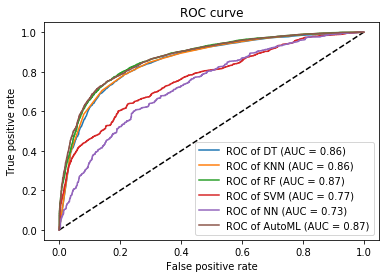

In [44]:


from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import autosklearn.classification

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

def roc_auc_curve(model,X_train,Y_train,X_test,Y_test):
  model.fit(X_train, Y_train)

  dt_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
  dt_lm.fit(X_test, Y_test)

  y_pred_dt = model.predict_proba(X_test)[:, 1]
  fpr_dt, tpr_dt, _ = roc_curve(Y_test, y_pred_dt)
  roc_auc = auc(fpr_dt, tpr_dt)
  
  test_acc_score = model.score(X_test,Y_test)
  
  return fpr_dt, tpr_dt,roc_auc,test_acc_score

# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0,max_depth=30,min_samples_leaf=20)
fpr_dt, tpr_dt,roc_auc,dt_test_acc_score = roc_auc_curve(clf,PCA_X_train,PCA_y_train,PCA_X_test,PCA_y_test)


#KNN 
knn = KNeighborsClassifier(n_neighbors=9)
knn_fpr, knn_tpr,knn_roc_auc,knn_test_acc_score = roc_auc_curve(knn,PCA_X_train,PCA_y_train,PCA_X_test,PCA_y_test)

#Random Forest 
rf = RandomForestClassifier(criterion ='gini', max_depth= 15, max_features= 'sqrt', min_samples_leaf=1, min_samples_split= 5, n_estimators= 300)
rf_fpr, rf_tpr,rf_roc_auc,rf_test_acc_score = roc_auc_curve(rf,PCA_X_train,PCA_y_train,PCA_X_test,PCA_y_test)

#svm 
svmModel = svm.SVC(C=1.0, gamma=0.1, kernel='rbf',probability=True) # Linear Kernel
svm_fpr, svm_tpr,svm_roc_auc,svm_test_acc_score = roc_auc_curve(svmModel,PCA_X_train,PCA_y_train,PCA_X_test,PCA_y_test)

#NN 
nn = MLPClassifier(alpha= 0.05, hidden_layer_sizes =(50, 100, 50),max_iter=500)
nn_fpr, nn_tpr,nn_roc_auc,nn_test_acc_score = roc_auc_curve(nn,PCA_X_train,PCA_y_train,PCA_X_test,PCA_y_test)

#AutoML 
AutoML = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          include_preprocessors=["no_preprocessing"]
          )
AutoML_fpr, AutoML_tpr,AutoML_roc_auc,AutoML_test_acc_score = roc_auc_curve(AutoML,PCA_X_train,PCA_y_train,PCA_X_test,PCA_y_test)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.plot(fpr_dt, tpr_dt, label='ROC of DT (AUC = %0.2f)' % roc_auc)
plt.plot(knn_fpr, knn_tpr, label='ROC of KNN (AUC = %0.2f)' % knn_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='ROC of RF (AUC = %0.2f)' % rf_roc_auc)
plt.plot(svm_fpr, svm_tpr, label='ROC of SVM (AUC = %0.2f)' % svm_roc_auc)
plt.plot(nn_fpr, nn_tpr, label='ROC of NN (AUC = %0.2f)' % nn_roc_auc)
plt.plot(AutoML_fpr, AutoML_tpr, label='ROC of AutoML (AUC = %0.2f)' % AutoML_roc_auc)


plt.title('ROC curve')
plt.legend(loc='best')
plt.show()




# Testing Accuracy Scores of all classifiers

In [45]:
scores = pd.DataFrame({"score":[dt_test_acc_score,
                       knn_test_acc_score,
                       rf_test_acc_score,
                       svm_test_acc_score,
                       nn_test_acc_score,
                       AutoML_test_acc_score],
                     "name":["dt_test_acc_score",
                       "knn_test_acc_score",
                       "rf_test_acc_score",
                       "svm_test_acc_score",
                       "nn_test_acc_score",
                       "AutoML_test_acc_score"]})
scores.sort_values(by=['score'])
scores

,score,name
0,0.793664,dt_test_acc_score
1,0.797280,knn_test_acc_score
2,0.805371,rf_test_acc_score
3,0.698029,svm_test_acc_score
4,0.705001,nn_test_acc_score
5,0.804425,AutoML_test_acc_score
